<a href="https://colab.research.google.com/github/orhansonmeztr/Bio-LLMs/blob/main/BioMedLM_biotech.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers -q
!pip install sacremoses -q
!pip install scann -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 33.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 28.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.6/880.6 kB 9.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 71.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 82.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.2/439.2 kB 31.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 52.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 65.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 88.1 MB/s eta 0:00:00


In [24]:
import os 
import json 
import torch
import numpy as np
import scann
import joblib
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModel
from sklearn.decomposition import TruncatedSVD, PCA

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("BioMedLM")
model = AutoModel.from_pretrained("BioMedLM")
tokenizer.pad_token = tokenizer.eos_token

In [ ]:
dset="biotech"
f = open('vec_vectorized_biotech_patents_transformed_ols.json', "r")
data = json.loads(f.read())
data_abst = [data[i]['abstract'] for i in range(len(data))]
data_title = [data[i]['title'] for i in range(len(data))]

In [ ]:
def normalizer(x):     
    normalized_vector = x / np.linalg.norm(x)
    return normalized_vector

class BioMedLM:
    
    def __init__(self, model, tokenizer):
        # self.sentence = sentence
        self.model = model
        self.tokenizer = tokenizer

    def sentence_vectors(self,sentence):
        inputs = self.tokenizer(sentence, padding=True, truncation=True, return_tensors="pt")
        w_vectors = self.model(**inputs)

        # return w_vectors
        token_embeddings = w_vectors[0] #First element of model_output contains all token embeddings
        input_mask_expanded = inputs.attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        vec=torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)
        return vec[0]

gpt_class = BioMedLM(model, tokenizer)

In [ ]:
def sentence_encoder(data):
    vectors = []
    normalized_vectors = []
    for i in range(len(data)):
        sentence_vectors = gpt_class.sentence_vectors(data[i]).detach().numpy()
        vectors.append(sentence_vectors)
        normalized_vectors.append(normalizer(sentence_vectors))

    vectors = np.squeeze(np.array(vectors))
    normalized_vectors = np.squeeze(np.array(normalized_vectors))

    return vectors, normalized_vectors

In [ ]:
abst_vectors, abst_vectors_norm = sentence_encoder(data_abst) 
title_vectors, title_vectors_norm = sentence_encoder(data_title) 

In [ ]:
print(abst_vectors_norm.shape, title_vectors_norm.shape)

In [ ]:
np.save('data_' + dset + '_abstract_BioMedLM.npy',abst_vectors)
np.save('data_' + dset + '_abstract_BioMedLM_norm.npy',abst_vectors_norm)

np.save('data_' + dset + '_title_BioMedLM.npy',title_vectors)
np.save('data_' + dset + '_title_BioMedLM_norm.npy',title_vectors_norm)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
os.chdir('/content/drive/MyDrive/vectors_via_biogpt_variants/')

In [6]:
def vector_normalizer(x):     
    normalized_vector = x / np.linalg.norm(x)
    return normalized_vector

def apk(actual, predicted, k=10):
    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0
    hits = []
    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)
        hits.append(num_hits)
    # if not actual:
    #     return 0.0
    # print(((hits)))
    return score / min(len(actual), k)

def mapk(actual, predicted, k=10):
    return np.mean([apk(a,p,k) for a,p in zip(actual, predicted)])

def intersect(actual, predicted,k):
    return np.intersect1d(actual[:k], predicted[:k])

def hit_rate(actual, predicted,k):
    total = 0
    for i in range(len(actual)):
        intersection = intersect(actual[i], predicted[i],k)
        total = total + len(intersection)

    return total


def mean_reciprocal_rank(idx, k):
    rank = []
    for i in range(len(idx)):
        rank.append(np.where(idx[i][:k] == i)[0])

    elevated_rank = np.add(rank,1)
    elevated_rank = np.concatenate(elevated_rank)
    elevated_rank_len = len(elevated_rank)
    reciprocal_rank = np.divide(1,elevated_rank)
    reciprocal_rank_sum = np.sum(reciprocal_rank)
    # print('asfasfasfas',len(idx))
    # return reciprocal_rank_sum/elevated_rank_len
    return reciprocal_rank_sum/len(idx)    

def dcg_calc(similarity_scores, K):
    similarity_len = len(similarity_scores)
    total_dcg = []
    for similarities in similarity_scores:
        dcg = 0
        for k in range(1,K):
            rel_k = similarities[k-1]
            dcg += rel_k / log2(1 + k)
        total_dcg.append(dcg)
    return np.sum(total_dcg)/similarity_len    

def metrics_calculator(raw_idx, reduced_idx, k_values):
    k = k_values
    ap = []
    hit = []
    #mrr = []
    for i in k:
        ap.append( mapk(raw_idx, reduced_idx,i))
        hit.append( hit_rate(raw_idx, reduced_idx,i))
        # mrr.append(mean_reciprocal_rank(reduced_idx, i))
    return ap, hit #, mrr

In [7]:
biotech_abstract_BioMedLM_norm = np.load('data_biotech_abstract_BioMedLM_norm.npy')
biotech_title_BioMedLM_norm = np.load('data_biotech_title_BioMedLM_norm.npy')
biotech_abstract_BioMedLM_norm.shape

(484, 2560)

In [10]:
pca_abstract_BioMedLM = PCA().fit(biotech_abstract_BioMedLM_norm)
pca_var_BioMedLM = np.cumsum(pca_abstract_BioMedLM.explained_variance_ratio_)

In [11]:
svd_abstract_BioMedLM = TruncatedSVD(n_iter= 25, n_components = 2560).fit(biotech_abstract_BioMedLM_norm)
svd_var_BioMedLM = np.cumsum(svd_abstract_BioMedLM.explained_variance_ratio_)

In [12]:
print('PCA 100% :',np.where(np.array(pca_var_BioMedLM) >= 0.99)[0][0])
print('PCA 95% :',np.where(np.array(pca_var_BioMedLM) >= 0.95)[0][0])
print('PCA 90% :',np.where(np.array(pca_var_BioMedLM) >= 0.90)[0][0])

print('SVD 100% :',np.where(np.array(svd_var_BioMedLM) >= 0.99)[0][0])
print('SVD 95% :',np.where(np.array(svd_var_BioMedLM) >= 0.95)[0][0])
print('SVD 90% :',np.where(np.array(svd_var_BioMedLM) >= 0.90)[0][0])

PCA 100% : 155
PCA 95% : 88
PCA 90% : 56
SVD 100% : 156
SVD 95% : 89
SVD 90% : 57


In [15]:
def pca_reducer(target_dimension, content, title):
    pca_name = '_pca_'+str(target_dimension)
    pca_ = PCA(n_components=target_dimension, random_state = 42, svd_solver = 'arpack')
    pca_.fit(content)
    content_vectors_pca = np.apply_along_axis(vector_normalizer,1,pca_.transform(content))
    title_vectors_pca = np.apply_along_axis(vector_normalizer,1,pca_.transform(title))

    inverse_content = pca_.inverse_transform(content_vectors_pca)
    inverse_title = pca_.inverse_transform(title_vectors_pca)

    np.save(dset + '_abst_vectors_norm'+pca_name,content_vectors_pca)
    np.save(dset + '_title_vectors_norm'+pca_name,title_vectors_pca)
    joblib.dump(pca_, pca_name)

def svd_reducer(target_dimension, content, title):
    svd_name = '_svd_'+str(target_dimension)
    svd_ = TruncatedSVD(n_iter= 25, n_components = target_dimension, random_state = 42 )
    svd_.fit(content)
    content_vectors_svd = np.apply_along_axis(vector_normalizer,1,svd_.transform(content))
    title_vectors_svd = np.apply_along_axis(vector_normalizer,1,svd_.transform(title))

    inverse_content = np.apply_along_axis(vector_normalizer,1,svd_.inverse_transform(content_vectors_svd))
    inverse_title = np.apply_along_axis(vector_normalizer,1,svd_.inverse_transform(title_vectors_svd))

    np.save(dset + '_abst_vectors_norm'+svd_name,content_vectors_svd)
    np.save(dset + '_title_vectors_norm'+svd_name,title_vectors_svd)
    joblib.dump(svd_, svd_name)

In [18]:
pca_reducer(57, biotech_abstract_BioMedLM_norm, biotech_title_BioMedLM_norm)
pca_reducer(89, biotech_abstract_BioMedLM_norm, biotech_title_BioMedLM_norm)
pca_reducer(156, biotech_abstract_BioMedLM_norm, biotech_title_BioMedLM_norm)
pca_reducer(107, biotech_abstract_BioMedLM_norm, biotech_title_BioMedLM_norm)

svd_reducer(57, biotech_abstract_BioMedLM_norm, biotech_title_BioMedLM_norm)
svd_reducer(89, biotech_abstract_BioMedLM_norm, biotech_title_BioMedLM_norm)
svd_reducer(156, biotech_abstract_BioMedLM_norm, biotech_title_BioMedLM_norm)
svd_reducer(107, biotech_abstract_BioMedLM_norm, biotech_title_BioMedLM_norm)

In [19]:
abstract_pca_57 = np.load(dset + '_abst_vectors_norm_pca_57.npy')
title_pca_57 = np.load(dset + '_title_vectors_norm_pca_57.npy')

abstract_pca_89 = np.load(dset + '_abst_vectors_norm_pca_89.npy')
title_pca_89 = np.load(dset + '_title_vectors_norm_pca_89.npy')

abstract_pca_156 = np.load(dset + '_abst_vectors_norm_pca_156.npy')
title_pca_156 = np.load(dset + '_title_vectors_norm_pca_156.npy')

abstract_pca_107 = np.load(dset + '_abst_vectors_norm_pca_107.npy')
title_pca_107 = np.load(dset + '_title_vectors_norm_pca_107.npy')


abstract_svd_57 = np.load(dset + '_abst_vectors_norm_svd_57.npy')
title_svd_57 = np.load(dset + '_title_vectors_norm_svd_57.npy')

abstract_svd_89 = np.load(dset + '_abst_vectors_norm_svd_89.npy')
title_svd_89 = np.load(dset + '_title_vectors_norm_svd_89.npy')

abstract_svd_156 = np.load(dset + '_abst_vectors_norm_svd_156.npy')
title_svd_156 = np.load(dset + '_title_vectors_norm_svd_156.npy')

abstract_svd_107 = np.load(dset + '_abst_vectors_norm_svd_107.npy')
title_svd_107 = np.load(dset + '_title_vectors_norm_svd_107.npy')

In [20]:
searcher_raw = scann.scann_ops_pybind.builder(biotech_abstract_BioMedLM_norm, 50, "dot_product").tree(
    num_leaves=200, num_leaves_to_search=100, training_sample_size=250000).score_ah(
    2, anisotropic_quantization_threshold=0.2).reorder(100).build()


searcher_pca_57 = scann.scann_ops_pybind.builder(abstract_pca_57, 50, "dot_product").tree(
    num_leaves=200, num_leaves_to_search=100, training_sample_size=250000).score_ah(
    2, anisotropic_quantization_threshold=0.2).reorder(100).build()

searcher_pca_89 = scann.scann_ops_pybind.builder(abstract_pca_89, 50, "dot_product").tree(
    num_leaves=200, num_leaves_to_search=100, training_sample_size=250000).score_ah(
    2, anisotropic_quantization_threshold=0.2).reorder(100).build()

searcher_pca_156 = scann.scann_ops_pybind.builder(abstract_pca_156, 50, "dot_product").tree(
    num_leaves=200, num_leaves_to_search=100, training_sample_size=250000).score_ah(
    2, anisotropic_quantization_threshold=0.2).reorder(100).build()

searcher_pca_107 = scann.scann_ops_pybind.builder(abstract_pca_107, 50, "dot_product").tree(
    num_leaves=200, num_leaves_to_search=100, training_sample_size=250000).score_ah(
    2, anisotropic_quantization_threshold=0.2).reorder(100).build()


searcher_svd_57 = scann.scann_ops_pybind.builder(abstract_svd_57, 50, "dot_product").tree(
    num_leaves=200, num_leaves_to_search=100, training_sample_size=250000).score_ah(
    2, anisotropic_quantization_threshold=0.2).reorder(100).build()

searcher_svd_89 = scann.scann_ops_pybind.builder(abstract_svd_89, 50, "dot_product").tree(
    num_leaves=200, num_leaves_to_search=100, training_sample_size=250000).score_ah(
    2, anisotropic_quantization_threshold=0.2).reorder(100).build()

searcher_svd_156 = scann.scann_ops_pybind.builder(abstract_svd_156, 50, "dot_product").tree(
    num_leaves=200, num_leaves_to_search=100, training_sample_size=250000).score_ah(
    2, anisotropic_quantization_threshold=0.2).reorder(100).build()

searcher_svd_107 = scann.scann_ops_pybind.builder(abstract_svd_107, 50, "dot_product").tree(
    num_leaves=200, num_leaves_to_search=100, training_sample_size=250000).score_ah(
    2, anisotropic_quantization_threshold=0.2).reorder(100).build()

In [21]:
raw_idx = []
reduced_idx_pca_57 = []
reduced_idx_svd_57 = []
reduced_idx_pca_89 = []
reduced_idx_svd_89 = []
reduced_idx_pca_156 = []
reduced_idx_svd_156 = []
reduced_idx_pca_107 = []
reduced_idx_svd_107 = []
for i in range(len(biotech_abstract_BioMedLM_norm)):
    raw_idx.append(searcher_raw.search(biotech_abstract_BioMedLM_norm[i])[0])
    reduced_idx_pca_57.append(searcher_pca_57.search(title_pca_57[i])[0])
    reduced_idx_svd_57.append(searcher_svd_57.search(title_svd_57[i])[0])
    reduced_idx_pca_89.append(searcher_pca_89.search(title_pca_89[i])[0])
    reduced_idx_svd_89.append(searcher_svd_89.search(title_svd_89[i])[0])
    reduced_idx_pca_156.append(searcher_pca_156.search(title_pca_156[i])[0])
    reduced_idx_svd_156.append(searcher_svd_156.search(title_svd_156[i])[0])
    reduced_idx_pca_107.append(searcher_pca_107.search(title_pca_107[i])[0])
    reduced_idx_svd_107.append(searcher_svd_107.search(title_svd_107[i])[0])

In [22]:
k = [1,3,5,10,15,20,30]
ap_pca_57, hit_pca_57 = metrics_calculator(raw_idx,reduced_idx_pca_57, k )
ap_svd_57, hit_svd_57 = metrics_calculator(raw_idx,reduced_idx_svd_57, k )

ap_pca_89, hit_pca_89 = metrics_calculator(raw_idx,reduced_idx_pca_89, k )
ap_svd_89, hit_svd_89 = metrics_calculator(raw_idx,reduced_idx_svd_89, k )

ap_pca_156, hit_pca_156 = metrics_calculator(raw_idx,reduced_idx_pca_156, k )
ap_svd_156, hit_svd_156 = metrics_calculator(raw_idx,reduced_idx_svd_156, k )

ap_pca_107, hit_pca_107 = metrics_calculator(raw_idx,reduced_idx_pca_107, k )
ap_svd_107, hit_svd_107 = metrics_calculator(raw_idx,reduced_idx_svd_107, k )

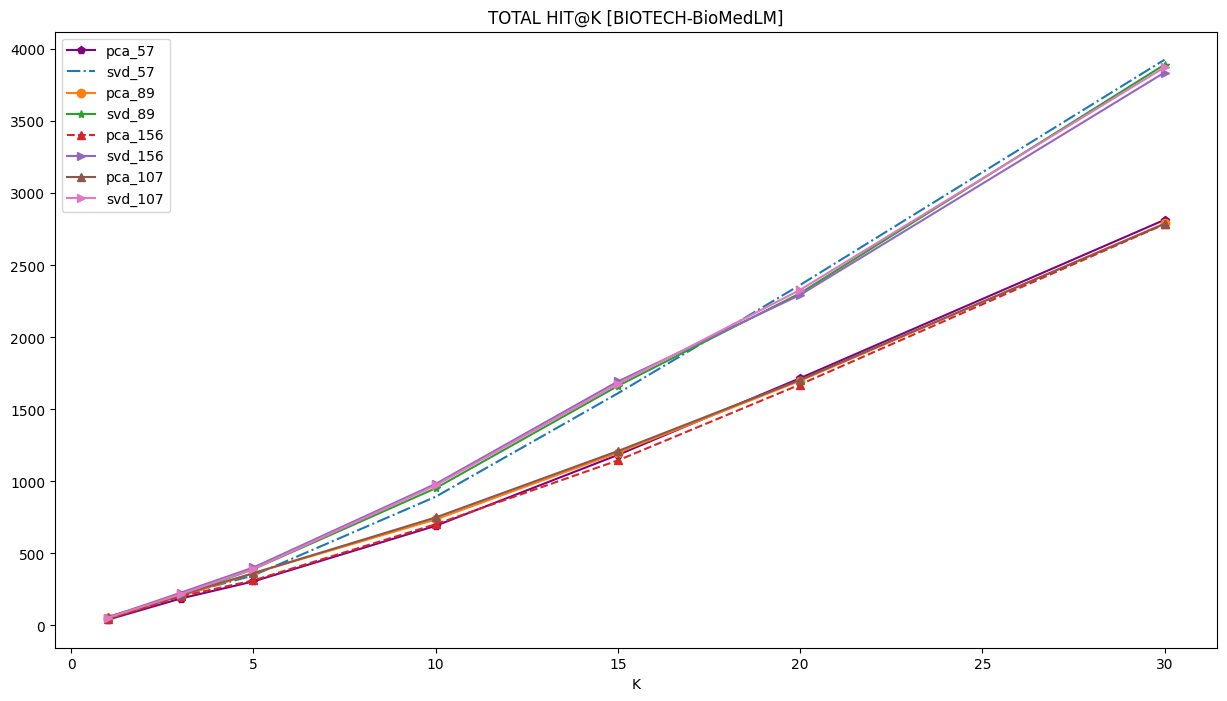

In [26]:
plt.figure(figsize =(15,8))
plt.plot(k,hit_pca_57, '-p', color = 'purple')
plt.plot(k,hit_svd_57, '-.')
plt.plot(k,hit_pca_89, '-o')
plt.plot(k,hit_svd_89, '-*')
plt.plot(k,hit_pca_156, '--^')
plt.plot(k,hit_svd_156, '>-')
plt.plot(k,hit_pca_107, '^-')
plt.plot(k,hit_svd_107, '->')

plt.title('TOTAL HIT@K [BIOTECH-BioMedLM]')
plt.legend(['pca_57','svd_57','pca_89','svd_89','pca_156','svd_156','pca_107','svd_107'])
plt.xlabel('K');

In [27]:
print(hit_pca_57)
print(hit_pca_89)
print(hit_pca_156)
print(hit_pca_107)
print("-"*50)
print(hit_svd_57)
print(hit_svd_89)
print(hit_svd_156)
print(hit_svd_107)

[40, 187, 306, 692, 1184, 1717, 2816]
[49, 204, 363, 736, 1199, 1699, 2791]
[45, 202, 313, 703, 1146, 1673, 2786]
[59, 212, 363, 750, 1211, 1705, 2788]
--------------------------------------------------
[46, 211, 348, 894, 1612, 2364, 3928]
[51, 208, 391, 953, 1663, 2307, 3894]
[55, 227, 403, 983, 1694, 2295, 3839]
[54, 217, 392, 973, 1678, 2330, 3875]
